In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2
env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax.numpy as np
import jax
from jax import random
key = random.PRNGKey(1)  # For seeding random numbers in JAX
# from jax.config import config
# config.update("jax_enable_x64", True)  # needed to switch from float32 to float64

In [4]:
import torch
import torch.nn as nn

/home/robby/anaconda3/envs/dorl/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
%matplotlib inline
import math
from tqdm import tqdm
import argparse
import os
import numpy as onp  # "Old" numpy
import matplotlib
import matplotlib.image
import matplotlib.pyplot
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import collections as mc
from matplotlib import rcParams, ticker, cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import HTML

rcParams['animation.html'] = 'jshtml'  # Makes the default animation an interactive video
rcParams['animation.embed_limit'] = 2**128  # Allow bigger animations
plt.style.use('seaborn-talk')  # also try 'seaborn-paper', 'fivethirtyeight'

In [6]:
from utils.metrics import get_discretized_tv_for_image_density
from utils.density import continuous_energy_from_image, prepare_image, sample_from_image_density, continuous_density_from_image
from utils.utils import viz_trajectories, vector_field, contour
from utils.flows import PlanarFlow, NormalizingFlow, train, plot_flow_density, plot_exact_density, gaussian_log_pdf, density_from_grid
from utils.hmc import hamiltonian_monte_carlo
import NPEET.npeet.entropy_estimators

### Visualize image

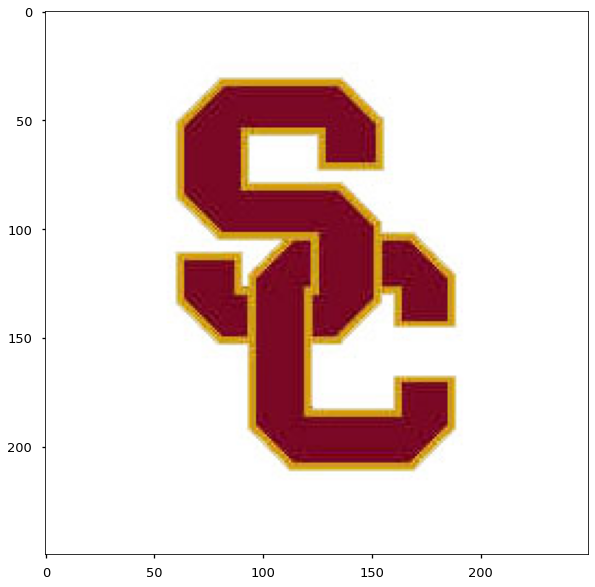

In [7]:
result_folder = "results"
image = "sc.jpeg"; crop = (0, 250, 0, 250)
# image = "blurry.jpeg"; crop = (10, 210, 10, 210)
(image_name, image_type) = image.split(".")

key = jax.random.PRNGKey(0)  # reset JAX random number seed
os.makedirs(f"{result_folder}", exist_ok=True)

# load some image
img = matplotlib.image.imread(f"./data/{image_name}.{image_type}")

# plot and visualize
fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img)
matplotlib.pyplot.show()

### Create density and energy from image

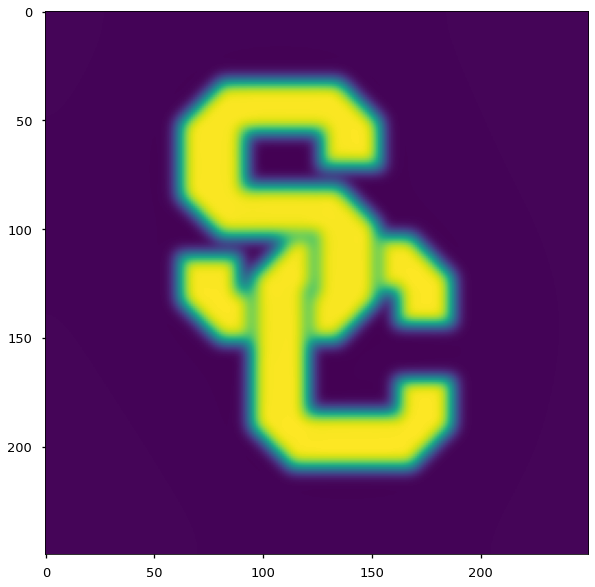

In [8]:
# convert to energy function
# first we get discrete energy and density values
density, energy = prepare_image(
    img, crop=crop, white_cutoff=225, gauss_sigma=3, background=0.01
)

fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(density)
matplotlib.pyplot.show()
fig.savefig(f"{result_folder}/{image_name}_density.png")

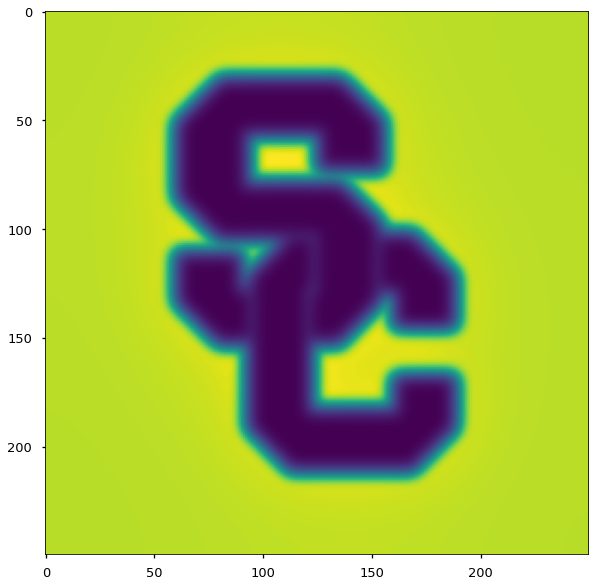

In [9]:
fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(energy)
matplotlib.pyplot.show()
fig.savefig(f"{result_folder}/{image_name}_energy.png")

### Create energy function and gradient

In [10]:
# create energy fn and its grad
x_max, y_max = density.shape
xp = jax.numpy.arange(x_max)
yp = jax.numpy.arange(y_max)
zp = jax.numpy.array(density)

# You may use fill value to enforce some boundary conditions or some other way to enforce boundary conditions
energy_fn = lambda coord: continuous_energy_from_image(coord, xp, yp, zp, fill_value=0)
energy_fn_grad = jax.grad(energy_fn)

In [11]:
device = 'cuda'
density_tensor = torch.from_numpy(density)
x_max, y_max = density.shape
size = min(density.shape)
xp = torch.arange(x_max).to(device)
yp = torch.arange(y_max).to(device)
zp = torch.from_numpy(density).to(device)

density_fn = lambda coord: continuous_density_from_image(coord, xp, yp, zp, size, 4.0, density_tensor, fill_value=0)

### Random sampling

[[198.83148  128.92027 ]
 [145.60782   77.16961 ]
 [111.33226  126.23866 ]
 ...
 [ 66.924255  63.79744 ]
 [178.9452   176.31989 ]
 [ 57.268578  71.99215 ]]


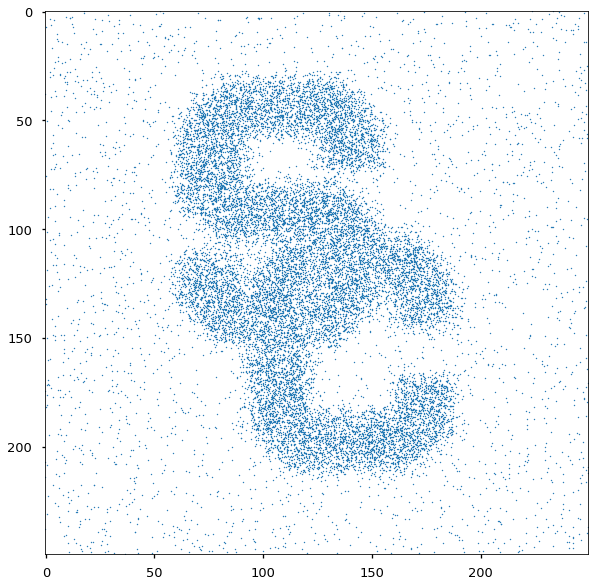

In [12]:
# NOTE: JAX makes it easy to compute fn and its grad, but you can use any other framework.
num_samples = 20_000

# generate samples from true distribution
key, subkey = jax.random.split(key)
samples = sample_from_image_density(num_samples, density, subkey)
print(samples)

# (scatter) plot the samples with image in background
fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(onp.array(samples)[:, 1], onp.array(samples)[:, 0], s=1.0, alpha=1.0)
ax.imshow(density, alpha=0.0)
matplotlib.pyplot.show()
fig.savefig(f"{result_folder}/{image_name}_sampled.png")

In [13]:
# generate another set of samples from true distribution, to demonstrate comparisons
key, subkey = jax.random.split(key)
second_samples = sample_from_image_density(num_samples, density, subkey)

# We have samples from two distributions. We use NPEET package to compute kldiv directly from samples.
# NPEET needs nxd tensors
kldiv = NPEET.npeet.entropy_estimators.kldiv(samples, second_samples)
print(f"KL divergence is {kldiv}")

# TV distance between discretized density
# The discrete density bin from the image give us a natural scale for discretization.
# We compute discrete density from sample at this scale and compute the TV distance between the two densities
tv_dist = get_discretized_tv_for_image_density(
    onp.asarray(density), onp.asarray(samples), bin_size=[7, 7]
)
print(f"TV distance is {tv_dist}")

KL divergence is 0.007626240662370314
TV distance is 0.15191417314765837


### Train normalizing flow

Heavily based off of [this codebase](https://github.com/MaximeVandegar/Papers-in-100-Lines-of-Code/blob/main/Variational_Inference_with_Normalizing_Flows/Flows.py)

### Simple density

In [94]:
w1 = lambda z: torch.sin((2 * np.pi * z[:, 0]) / 4)
w2 = lambda z: 3 * torch.exp(-(((z[:, 0] - 1) / 0.6) ** 2) / 2)
w3 = lambda z: 3 * 1 / (1 + torch.exp(- ((z[:, 0] - 1) / 0.3)))
# Energy functions
U1 = lambda z: (((torch.sqrt(z[:, 0] ** 2 + z[:, 1] ** 2) - 2) / 0.4) ** 2) / 2 - torch.log(
    1e-15 + (torch.exp(-(((z[:, 0] - 2) / 0.6) ** 2) / 2) + torch.exp(-(((z[:, 0] + 2) / 0.6) ** 2) / 2)))
U2 = lambda z: (((z[:, 1] - w1(z)) / 0.4) ** 2) / 2
U3 = lambda z: - torch.log(1e-15 + torch.exp(-(((z[:, 1] - w1(z)) / 0.35) ** 2) / 2) + torch.exp(
    -(((z[:, 1] - w1(z) + w2(z)) / 0.35) ** 2) / 2))
U4 = lambda z: - torch.log(1e-15 + torch.exp(-(((z[:, 1] - w1(z)) / 0.4) ** 2) / 2) + torch.exp(
    -(((z[:, 1] - w1(z) + w3(z)) / 0.35) ** 2) / 2))

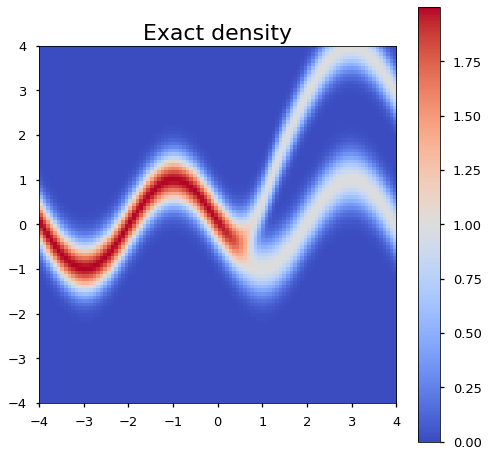

In [112]:
U = U4
exact_log_density = lambda z: - U(z)

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
fig.set_size_inches(8, 8, forward=True)
plot = plot_exact_density(ax, exact_log_density, title="Exact density")
fig.colorbar(plot)

In [113]:
x1 = torch.tensor([[-1000, -1000]])
exact_log_density(x1)

tensor([-34.5388])

In [114]:
device = 'cuda:0'; data_dim = 2
flow_length = 12
flow = NormalizingFlow(flow_length, data_dim).to(device)
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-2)
loss = train(flow, optimizer, 500, exact_log_density, 4096, data_dim, device)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:24<00:00, 20.51it/s]


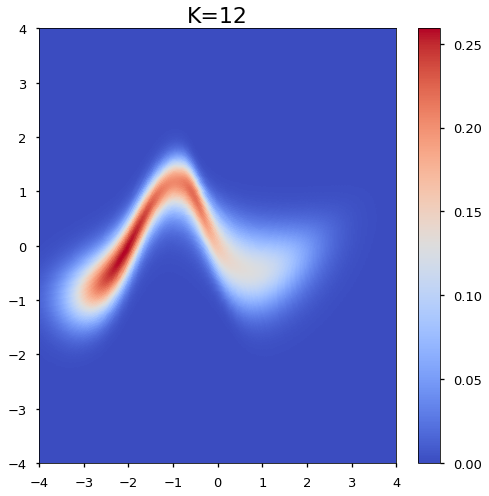

In [115]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
fig.set_size_inches(8, 8, forward=True)
plot = plot_flow_density(flow, ax, device, title=f'K={flow_length}')
# lims=onp.array([[-40, 40], [-40, 40]])
fig.colorbar(plot)

### Complex density

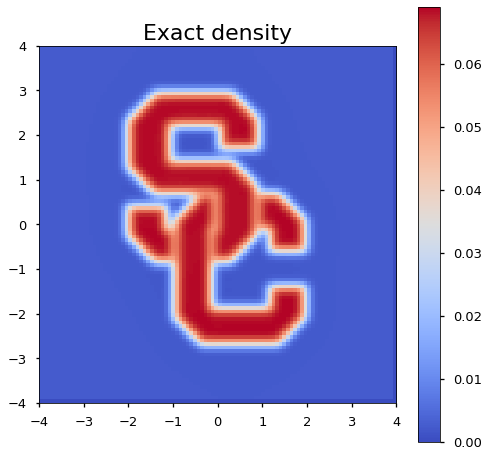

In [218]:
density_tensor = torch.from_numpy(density)
size = min(density_tensor.shape)
# exact_log_density = lambda xs: density_from_grid(xs, density_tensor, c=4.0)
exact_log_density = lambda xs: density_fn(torch.permute(xs, (1, 0)))

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
fig.set_size_inches(8, 8, forward=True)
plot = plot_exact_density(ax, exact_log_density, title="Exact density", lims=onp.array([[-4.0, 4.0], [-4.0, 4.0]]))
fig.colorbar(plot)

In [275]:
device = 'cuda'; data_dim = 2
flow_length = 20
flow = NormalizingFlow(flow_length, data_dim).to(device)
optimizer = torch.optim.Adam(flow.parameters(), lr=3e-3)
loss = train(flow, optimizer, 3000, exact_log_density, 4096, data_dim, device)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [02:26<00:00, 20.44it/s]


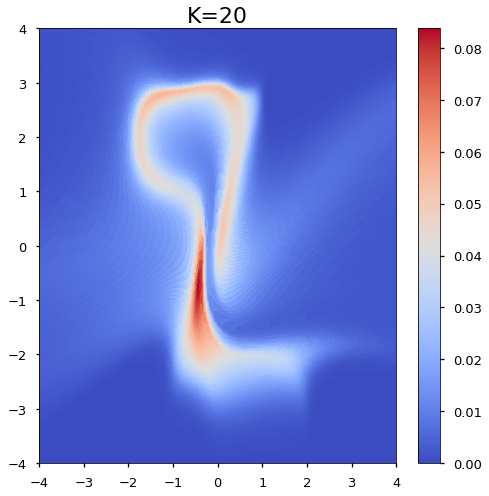

In [276]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
fig.set_size_inches(8, 8, forward=True)
plot = plot_flow_density(flow, ax, device, title=f'K={flow_length}', lims=onp.array([[-4., 4.], [-4., 4.]]))
# plot = plot_flow_density(flow, ax, device, title=f'K={flow_length}', lims=onp.array([[-40., 40.], [-40., 40.]]))
# plot = plot_flow_density(flow, ax, device, title=f'K={flow_length}', lims=onp.array([[-400., 400.], [-400., 400.]]))

fig.colorbar(plot)

In [278]:
z0 = torch.randn(20_000, 2).to(device)
z0

tensor([[ 0.7335, -0.5659],
        [ 1.2558,  0.8370],
        [-0.3445, -0.2070],
        ...,
        [-1.3286,  1.8262],
        [ 1.2262,  1.0101],
        [-0.3399,  0.7636]], device='cuda:0')

In [285]:
zk, log_jacobian = flow(z0)
samples = zk.detach().cpu().numpy()
size = min(density_tensor.shape)
c = 4.0
samples = (samples + c) * size / (2 * c) 
samples

array([[ 72.271126,  44.96041 ],
       [490.2543  ,  57.2081  ],
       [110.899536, 153.97276 ],
       ...,
       [383.9947  , 256.68735 ],
       [521.8719  ,  80.702576],
       [146.1971  , 158.3666  ]], dtype=float32)

In [286]:
# generate another set of samples from true distribution, to demonstrate comparisons
key, subkey = jax.random.split(key)
second_samples = sample_from_image_density(20_000, density, subkey)

print(second_samples)

# We have samples from two distributions. We use NPEET package to compute kldiv directly from samples.
# NPEET needs nxd tensors
kldiv = NPEET.npeet.entropy_estimators.kldiv(samples, second_samples)
print(f"KL divergence is {kldiv}")

# TV distance between discretized density
# The discrete density bin from the image give us a natural scale for discretization.
# We compute discrete density from sample at this scale and compute the TV distance between the two densities
tv_dist = get_discretized_tv_for_image_density(
    onp.asarray(density), onp.asarray(samples), bin_size=[7, 7]
)
print(f"TV distance is {tv_dist}")

[[1.61034943e+02 1.90034943e+02]
 [7.93477173e+01 1.18757416e+02]
 [8.21098557e+01 6.19949455e+01]
 ...
 [1.05562668e+02 1.09147163e+02]
 [1.77734256e-01 2.00206024e+02]
 [9.45301666e+01 8.47509918e+01]]
KL divergence is 4.449181568454987
TV distance is 0.9272995366008991
